# 📝 Exercise M6.03

The aim of this exercise is to:

* verifying if a random forest or a gradient-boosting decision tree overfit
  if the number of estimators is not properly chosen;
* use the early-stopping strategy to avoid adding unnecessary trees, to
  get the best generalization performances.

We will use the California housing dataset to conduct our experiments.

In [1]:
from sklearn.datasets import fetch_california_housing
from sklearn.model_selection import train_test_split

data, target = fetch_california_housing(return_X_y=True, as_frame=True)
target *= 100  # rescale the target in k$
data_train, data_test, target_train, target_test = train_test_split(
    data, target, random_state=0, test_size=0.5)

<div class="admonition note alert alert-info">
<p class="first admonition-title" style="font-weight: bold;">Note</p>
<p class="last">If you want a deeper overview regarding this dataset, you can refer to the
Appendix - Datasets description section at the end of this MOOC.</p>
</div>

Create a gradient boosting decision tree with `max_depth=5` and
`learning_rate=0.5`.

In [7]:
from sklearn.ensemble import GradientBoostingRegressor

gbdt = GradientBoostingRegressor(max_depth=5, learning_rate=0.5)


Also create a random forest with fully grown trees by setting `max_depth=None`.

In [8]:
from sklearn.ensemble import RandomForestRegressor

forest = RandomForestRegressor(max_depth=None)


For both the gradient-boosting and random forest models, create a validation
curve using the training set to assess the impact of the number of trees on
the performance of each model. Evaluate the list of parameters `param_range =
[1, 2, 5, 10, 20, 50, 100]` and use the mean absolute error.

In [9]:
# solution
from sklearn.model_selection import validation_curve

param_range = [1, 2, 5, 10, 20, 50, 100]
gbdt_train_scores, gbdt_validation_scores = validation_curve(
    gbdt,
    data_train,
    target_train,
    param_name="n_estimators",
    param_range=param_range,
    scoring="neg_mean_absolute_error",
    n_jobs=2,
)
gbdt_train_errors, gbdt_validation_errors = -gbdt_train_scores, -gbdt_validation_scores

forest_train_scores, forest_validation_scores = validation_curve(
    forest,
    data_train,
    target_train,
    param_name="n_estimators",
    param_range=param_range,
    scoring="neg_mean_absolute_error",
    n_jobs=2,
)
forest_train_errors = -forest_train_scores
forest_validation_errors = -forest_validation_scores

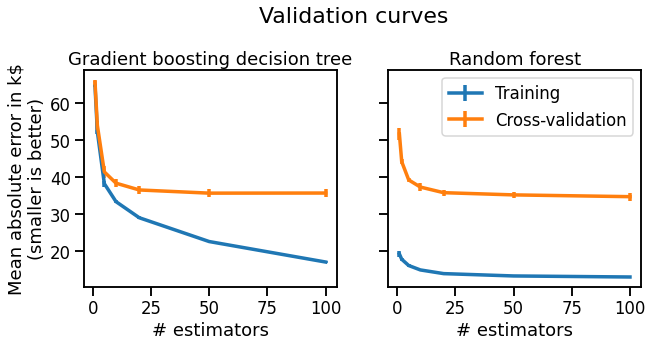

In [10]:
import matplotlib.pyplot as plt

fig, axs = plt.subplots(ncols=2, sharex=True, sharey=True, figsize=(10, 4))

axs[0].errorbar(
    param_range,
    gbdt_train_errors.mean(axis=1),
    yerr=gbdt_train_errors.std(axis=1),
    label="Training",
)
axs[0].errorbar(
    param_range,
    gbdt_validation_errors.mean(axis=1),
    yerr=gbdt_validation_errors.std(axis=1),
    label="Cross-validation",
)
axs[0].set_title("Gradient boosting decision tree")
axs[0].set_xlabel("# estimators")
axs[0].set_ylabel("Mean absolute error in k$\n(smaller is better)")

axs[1].errorbar(
    param_range,
    forest_train_errors.mean(axis=1),
    yerr=forest_train_errors.std(axis=1),
    label="Training",
)
axs[1].errorbar(
    param_range,
    forest_validation_errors.mean(axis=1),
    yerr=forest_validation_errors.std(axis=1),
    label="Cross-validation",
)
axs[1].set_title("Random forest")
axs[1].set_xlabel("# estimators")

plt.legend()
_ = fig.suptitle("Validation curves", y=1.1)

Both gradient boosting and random forest models will always improve when
increasing the number of trees in the ensemble. However, it will reach a
plateau where adding new trees will just make fitting and scoring slower.

To avoid adding new unnecessary tree, unlike random-forest gradient-boosting
offers an early-stopping option. Internally, the algorithm will use an
out-of-sample set to compute the generalization performance of the model at
each addition of a tree. Thus, if the generalization performance is not
improving for several iterations, it will stop adding trees.

Now, create a gradient-boosting model with `n_estimators=1_000`. This number
of trees will be too large. Change the parameter `n_iter_no_change` such
that the gradient boosting fitting will stop after adding 5 trees that do not
improve the overall generalization performance.

In [11]:
# solution
gbdt = GradientBoostingRegressor(n_estimators=1_000, n_iter_no_change=5)
gbdt.fit(data_train, target_train)
gbdt.n_estimators_

253

Estimate the generalization performance of this model again using
the `sklearn.metrics.mean_absolute_error` metric but this time using
the test set that we held out at the beginning of the notebook.
Compare the resulting value with the values observed in the validation
curve.

In [12]:
# solution
from sklearn.metrics import mean_absolute_error
error = mean_absolute_error(target_test, gbdt.predict(data_test))
print(f"On average, our GBDT regressor makes an error of {error:.2f} k$")

On average, our GBDT regressor makes an error of 34.39 k$
